# Bayesian Rules for Deciding when to Play Tennis

This uses a "*Toy Decision*" dataset based on the example from Tom Mitchell's Machine Learning book, see section 3.4.2 (page 59 in Alexander's edition).

Since this dataset is extremely simple, we'll use this to explore how different structures might influence the rules produced by the Gopalakrishnan algorithm.

In [ ]:
# If you're running in colab, run this cell for setup.
! apt install libgraphviz-dev
! pip install pomegranate numpy pandas matplotlib pygraphviz
! pip install git+https://github.com/hayesall/bn-rule-extraction.git

In [1]:
from bayes_rule_extraction import ordinal_encode, print_rules
from pomegranate import BayesianNetwork
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/hayesall/bn-rule-extraction/main/toy_decision.csv")
data

,PlayTennis,Outlook,Temperature,Humidity,Wind
0,no,sunny,hot,high,weak
1,no,sunny,hot,high,strong
2,yes,overcast,hot,high,weak
3,yes,rain,mild,high,weak
4,yes,rain,cool,normal,weak
5,no,rain,cool,normal,strong
6,yes,overcast,cool,normal,strong
7,no,sunny,mild,high,weak
8,yes,sunny,cool,normal,weak
9,yes,rain,mild,normal,weak


In [2]:
encoded, mapping = ordinal_encode(data.columns, data)

encoded

array([[0., 2., 1., 0., 1.],
       [0., 2., 1., 0., 0.],
       [1., 0., 1., 0., 1.],
       [1., 1., 2., 0., 1.],
       [1., 1., 0., 1., 1.],
       [0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 2., 2., 0., 1.],
       [1., 2., 0., 1., 1.],
       [1., 1., 2., 1., 1.],
       [1., 2., 2., 1., 0.],
       [1., 0., 2., 0., 0.],
       [1., 0., 1., 1., 1.],
       [0., 1., 2., 0., 0.]], dtype=float32)

## Extreme Case: Naive Bayes

Naive Bayes assumes that the variables are conditionally independent given the label. We'll represent this by passing a fixed structure where all of the variables have `PlayTennis` (0) as a parent.

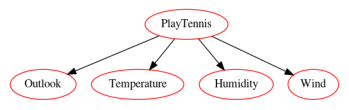

In [3]:
naive_model = BayesianNetwork.from_structure(
    encoded,
    structure=((), (0,), (0,), (0,), (0,)),
    state_names=data.columns,
)

naive_model.plot()

The network seems backwards to a sensible causal story (*Not playing tennis causes high humidity*), but this looks reasonable for making some guesses like: "*On days when tennis is played, the humidity is probably normal.*"

In [4]:
print_rules(naive_model, data.columns, mapping)

Probabilities:
- PlayTennis
  P( PlayTennis = no ) = 0.36
  P( PlayTennis = yes ) = 0.64

IF (PlayTennis = no) THEN (Outlook = sunny)
	CF = 1.50
IF (PlayTennis = no) THEN (Humidity = high)
	CF = 4.00
IF (PlayTennis = yes) THEN (Humidity = normal)
	CF = 2.00
IF (PlayTennis = no) THEN (Wind = strong)
	CF = 1.50
IF (PlayTennis = yes) THEN (Wind = weak)
	CF = 2.00


## Inverting the Naive Bayes Edges

Since I suggested a causal interpretation of the edges, you might be curious what the rules look like if we flip the direction of all the arrows to say something like: *Playing tennis is caused by 4 independent variables.*

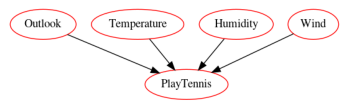

In [5]:
flipped_naive_bayes = BayesianNetwork.from_structure(
    encoded,
    structure=((1, 2, 3, 4), (), (), (), ()),
    state_names=data.columns,
)

flipped_naive_bayes.plot()

I'll include this as a warning for something that might *seem* like a good idea but isn't. Any extracted rule would have to be the conjunction over all variables, and there are an exponential number of those proportional to the number of values each variable can have (in this case, 58 rules had confidence $\ge$ 1.0).

In [6]:
print_rules(flipped_naive_bayes, data.columns, mapping)

Probabilities:
- Outlook
  P( Outlook = sunny ) = 0.36
  P( Outlook = overcast ) = 0.29
  P( Outlook = rain ) = 0.36
- Temperature
  P( Temperature = hot ) = 0.29
  P( Temperature = mild ) = 0.43
  P( Temperature = cool ) = 0.29
- Humidity
  P( Humidity = high ) = 0.50
  P( Humidity = normal ) = 0.50
- Wind
  P( Wind = weak ) = 0.57
  P( Wind = strong ) = 0.43

IF (Outlook = overcast ^ Temperature = cool ^ Humidity = high ^ Wind = strong) THEN (PlayTennis = no)
	CF = 1.00
IF (Outlook = overcast ^ Temperature = cool ^ Humidity = high ^ Wind = strong) THEN (PlayTennis = yes)
	CF = 1.00
IF (Outlook = overcast ^ Temperature = cool ^ Humidity = high ^ Wind = weak) THEN (PlayTennis = no)
	CF = 1.00
IF (Outlook = overcast ^ Temperature = cool ^ Humidity = high ^ Wind = weak) THEN (PlayTennis = yes)
	CF = 1.00
IF (Outlook = overcast ^ Temperature = cool ^ Humidity = normal ^ Wind = strong) THEN (PlayTennis = yes)
	CF = inf
IF (Outlook = overcast ^ Temperature = cool ^ Humidity = normal ^ Wind 

/home/hayesall/Classes/bn-rule-extraction/bayes_rule_extraction/bayes_rule_extraction.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  _conf_factor = row[-1] / (1 - row[-1])


## Structure Learning + Rule Extraction for the Binary Classification Case

We can encode "PlayTennis should not be the parent of any other node" using the `exclude_edges` parameter with a list of tuples:

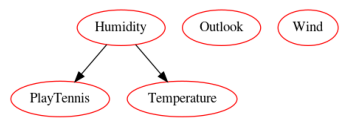

In [7]:
excluded_edges = [tuple([0, i]) for i in range(1, len(data.columns))]

binary_model = BayesianNetwork().from_samples(
    encoded,
    algorithm="exact",
    exclude_edges=excluded_edges,
    state_names=data.columns,
    max_parents=-1,
)

binary_model.plot()

In [8]:
print_rules(binary_model, data.columns, mapping)

Probabilities:
- Outlook
  P( Outlook = overcast ) = 0.29
  P( Outlook = rain ) = 0.36
  P( Outlook = sunny ) = 0.36
- Humidity
  P( Humidity = high ) = 0.50
  P( Humidity = normal ) = 0.50
- Wind
  P( Wind = strong ) = 0.43
  P( Wind = weak ) = 0.57

IF (Humidity = high) THEN (PlayTennis = no)
	CF = 1.33
IF (Humidity = normal) THEN (PlayTennis = yes)
	CF = 6.00
IF (Humidity = high) THEN (Temperature = mild)
	CF = 1.33
IF (Humidity = normal) THEN (Temperature = cool)
	CF = 1.33


## Using a structure based on some prior knowledge

I found this structure while searching for ones that produced the best leave-one-out-cross-validation accuracy. The causal interpretation seems tenuous&mdash;it seems like a sunny or overcast outlook should affect the temperature. But it also seems overly optimistic to expect causal explanations from the fictional world this data was drawn from.

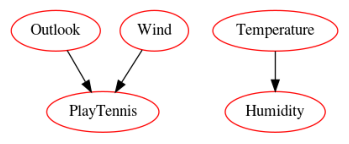

In [9]:
known_structure_model = BayesianNetwork.from_structure(
    encoded,
    structure=((1, 4), (), (), (2,), ()),
    state_names=data.columns,
)

known_structure_model.plot()

In [23]:
print_rules(known_structure_model, data.columns, mapping)

Probabilities:
- Outlook
  P( Outlook = sunny ) = 0.36
  P( Outlook = overcast ) = 0.29
  P( Outlook = rain ) = 0.36
- Temperature
  P( Temperature = hot ) = 0.29
  P( Temperature = mild ) = 0.43
  P( Temperature = cool ) = 0.29
- Wind
  P( Wind = weak ) = 0.57
  P( Wind = strong ) = 0.43

IF (Outlook = overcast ^ Wind = strong) THEN (PlayTennis = yes)
	CF = inf
IF (Outlook = overcast ^ Wind = weak) THEN (PlayTennis = yes)
	CF = inf
IF (Outlook = rain ^ Wind = strong) THEN (PlayTennis = no)
	CF = inf
IF (Outlook = rain ^ Wind = weak) THEN (PlayTennis = yes)
	CF = inf
IF (Outlook = sunny ^ Wind = strong) THEN (PlayTennis = no)
	CF = 1.00
IF (Outlook = sunny ^ Wind = strong) THEN (PlayTennis = yes)
	CF = 1.00
IF (Outlook = sunny ^ Wind = weak) THEN (PlayTennis = no)
	CF = 2.00
IF (Temperature = cool) THEN (Humidity = normal)
	CF = inf
IF (Temperature = hot) THEN (Humidity = high)
	CF = 3.00
IF (Temperature = mild) THEN (Humidity = high)
	CF = 2.00


/home/hayesall/Classes/bn-rule-extraction/bayes_rule_extraction/bayes_rule_extraction.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  for j, par in enumerate([variable_names[p] for p in pom_model.structure[i]]):


## Ideas and Further Thoughts

### Rules with equally likely outcomes

It's pretty common to find cases where we could refine the rules. Consider these two cases:

```python
if (Outlook == "sunny" and Wind == "strong"):
    PlayTennis = ("no", 1.0)

if (Outlook == "sunny" and Wind == "strong"):
    PlayTennis = ("yes", 1.0)
```

(1) The conditions are the same, (2) the confidence factors for both outcomes are the same, but (3) the *outcomes are different*. This might be refined to say something like: "*If the outlook is sunny and the wind is strong, it's equally likely that the person plays tennis.*"

---

### Being Infinitely confident

Now consider a case like this:

```python
if (Outlook == "overcast" and Wind == "strong"):
    PlayTennis = ("yes", inf)
```

This occurs here because we have two examples where the outlook is overcast and the wind is strong; and our imaginary user played tennis on both days:

```console
   PlayTennis   Outlook    Wind
-------------------------------
6         yes  overcast  strong
11        yes  overcast  strong
?          no  overcast  strong    <-- never observed in the training data
```

There are two interpretations for "infinite confidence" here. Either (1) the relationship is determinitic and the user always plays tennis on overcast, windy days; or (2) we didn't didn't observe enough cases to adequately assess how confident we should be.

Extracting rules from the Bayes net resulted in four of these:

```python
if (Outlook == "overcast" and Wind == "strong"):
    PlayTennis = ("yes", inf)
if (Outlook == "overcast" and Wind == "weak"):
    PlayTennis = ("yes", inf)
if (Outlook == "rain" and Wind == "strong"):
    PlayTennis = ("no", inf)
if (Outlook == "rain" and Wind == "weak"):
    PlayTennis = ("yes", inf)
```

I suspect this could help reveal deterministic paths within uncertain models, shed light on cases where domain expertise or more data are required, or perhaps reveal "bugs" in the data where a variable that should be dependent on another was incorrectly recorded.